In [834]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [835]:
# Define the path to the CSV file
file_path = './data/sales_train_evaluation.csv'

# Read the CSV file into a DataFrame
sales_df = pd.read_csv(file_path)


In [836]:
# Define the path to the CSV file
file_path = './data/calendar.csv'

# Read the CSV file into a DataFrame
calendar_df = pd.read_csv(file_path)


In [837]:
# Define the path to the CSV file
file_path = './data/sell_prices.csv'

# Read the CSV file into a DataFrame
prices_df = pd.read_csv(file_path)


In [838]:
sales_df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [839]:
sales_df.shape

(30490, 1947)

In [840]:
# Reshaping the data from wide to long format, as to use days easier

sales_long = sales_df.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='day',
    value_name='sales'
)

In [841]:
sales_long["cat_id"].value_counts()

cat_id
FOODS        27892170
HOUSEHOLD    20322270
HOBBIES      10966650
Name: count, dtype: int64

In [842]:
hobbies_sales_long = sales_long[sales_long['cat_id'] == 'HOBBIES']

In [843]:
hobbies_sales_long.shape

(10966650, 8)

In [844]:
ca_hobbies_sales_long = hobbies_sales_long[hobbies_sales_long['state_id'] == 'CA']

In [845]:
ca_hobbies_sales_long.shape

(4386660, 8)

In [846]:
## All SKU in Hobbie Department, within Primary Store in California
# About 1.1 M entries

alpha_ca_hobbies_sales_long = ca_hobbies_sales_long[ca_hobbies_sales_long['store_id'] == 'CA_1']

In [847]:
alpha_ca_hobbies_sales_long.shape

(1096665, 8)

In [848]:
## A specific single SKU in Hobbie Department, within Primary Store in California

filtered_sales_df = alpha_ca_hobbies_sales_long[alpha_ca_hobbies_sales_long['item_id'] == 'HOBBIES_1_001']

In [849]:
filtered_sales_df.shape

(1941, 8)

In [850]:
filtered_sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
30490,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
60980,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
91470,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
121960,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0


In [851]:
# Convert the 'day' column to an integer representing the day number
filtered_sales_df['day_num'] = filtered_sales_df['day'].str.extract('d_(\d+)').astype(int)

# Assume the first day is 2011-01-29, add the day numbers to get actual dates
start_date = datetime.datetime(2011, 1, 29)
filtered_sales_df['date'] = filtered_sales_df['day_num'].apply(lambda x: start_date + datetime.timedelta(days=x-1))

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rafae\AppData\Local\Temp\ipykernel_19636\939334016.py:2: SyntaxWarning: invalid escape sequence '\d'
  filtered_sales_df['day_num'] = filtered_sales_df['day'].str.extract('d_(\d+)').astype(int)
C:\Users\rafae\AppData\Local\Temp\ipykernel_19636\939334016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales_df['day_num'] = filtered_sales_df['day'].str.extract('d_(\d+)').astype(int)
C:\Users\rafae\AppData\Local\Temp\ipykernel_19636\939334016.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [852]:
# Sort by id and date before creating rolling features
filtered_sales_df = filtered_sales_df.sort_values(by=['id', 'date'])

# Create a 7-day rolling average
filtered_sales_df['rolling_avg_7'] = filtered_sales_df.groupby('id')['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean().round(2))
filtered_sales_df['rolling_avg_30'] = filtered_sales_df.groupby('id')['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean().round(2))



In [853]:
# Defining function used below, to slice and therefore standardize formats between dfs

def day_slicer(row):
    slice_list = row.split("_")
    return slice_list[1]

In [854]:

calendar_df['d'] = calendar_df['d'].apply(day_slicer)

calendar_df.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0


In [855]:
filtered_sales_df['date'] = pd.to_datetime(single_alpha_ca_hobbies_sales_long['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [856]:
# This function fecthes the following attributes from calendar_df and pastes them to sales_df
# snap, based on state
# weekday and if is_weekend
# events of each day, if any

def fetch_calendar_info(row):
    # Filter calendar_df for the matching date
    calendar_row = calendar_df[calendar_df['date'] == row['date']]
    
    # Retrieve the relevant snap value based on the state
    if not calendar_row.empty:
        if row['state_id'] == 'CA':
            row['snap'] = calendar_row['snap_CA'].values[0]
        elif row['state_id'] == 'TX':
            row['snap'] = calendar_row['snap_TX'].values[0]
        elif row['state_id'] == 'WI':
            row['snap'] = calendar_row['snap_WI'].values[0]
        
    # Fetching add weekday from calendar_df
        row['weekday'] = calendar_row['weekday'].values[0]

    # Fetching Event_1
        row["event_name_1"] = calendar_row["event_name_1"].values[0]
        row["event_type_1"] = calendar_row["event_type_1"].values[0]

    # Fetching Event_2, if it is not NaN
        row["event_name_2"] = calendar_row["event_name_2"].values[0]
        row["event_type_2"] = calendar_row["event_type_2"].values[0]
    
    else:
        
    # Empty Error Handling
        row['snap'] = None  # or a default value
        row['weekday'] = None
        row["event_name_1"] = None
        row["event_type_1"] = None
        row["event_name_2"] = None
        row["event_type_2"] = None
        

    # Flag Weekend (Binary)
    if row["weekday"] == "Saturday" or row["weekday"] == "Sunday":
        row["is_weekend"] = 1
    else:
        row["is_weekend"] = 0

    return row

In [857]:
filtered_sales_df = filtered_sales_df.apply(fetch_calendar_info, axis=1)

In [858]:
filtered_sales_df.tail(1)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,day_num,date,rolling_avg_7,rolling_avg_30,snap,weekday,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend
59150600,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1941,1,1941,2016-05-22,1.0,1.17,0,Sunday,NaN,NaN,NaN,NaN,1


In [859]:
calendar_df.tail(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1968,2016-06-19,11621,Sunday,2,6,2016,1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


_________________________________

In [860]:
#### MODEL STARTS HERE

In [861]:
# Example: Assume 'sales' is your target variable
target_column = 'rolling_avg_7'
X = filtered_sales_df.drop(columns=[target_column])
y = filtered_sales_df[target_column]

In [862]:
## XGBoost works with numericals

X = pd.get_dummies(X)

In [863]:
# Training the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [864]:
X_train['day'] = X_train['date'].dt.day
X_train['month'] = X_train['date'].dt.month
X_train['year'] = X_train['date'].dt.year

X_test['day'] = X_test['date'].dt.day
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year

# Drop the original 'date' column after extracting features
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])

In [865]:
# Initialize the Model: Set up the model with default parameters or customize them as needed.

model = XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Step size shrinkage
    max_depth=5,                   # Maximum depth of trees
    random_state=42,                # Seed for reproducibility
    enable_categorical=True
)

In [866]:
param_grid = {
    'n_estimators': [250, 500],              # Number of trees
    'learning_rate': [0.01, 0.2],      # Step size shrinkage
    'max_depth': [3, 10],                   # Maximum depth of trees
    'subsample': [0.5, 1.0],                 # Fraction of samples for each tree
    'colsample_bytree': [0.6, 1.0],          # Fraction of features for each tree
    'reg_alpha': [0, 0.1],                  # L1 regularization
    'reg_lambda': [1, 2]                     # L2 regularization
}

In [867]:
best_grid = {'colsample_bytree': [1.0],
             'learning_rate': [0.2],
             'max_depth': [3],
             'n_estimators': [500],
             'reg_alpha': [0],
             'reg_lambda': [1],
             'subsample': [1.0]
}

#Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}

In [868]:
# Step 4: Set up GridSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # This respects the order of time-series data

grid_search = GridSearchCV(
    estimator=model,
    param_grid=best_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',  # Choose a scoring metric
    verbose=2,
    n_jobs=-1
)

# Step 5: Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Step 6: Retrieve the best model from GridSearchCV
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}


In [869]:
y_pred = best_model.predict(X_test)

In [870]:
non_zero_indices = y_test != 0

In [875]:
# MAE, Measures the average magnitude of errors in predictions, without considering their direction. Lower is better.
mae = mean_absolute_error(y_test, y_pred)

# RMSE, Measures the average magnitude of errors, with a larger penalty for bigger errors. Lower is better.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R2, Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. 
# A higher value, closer to 1, is generally better.
r2 = r2_score(y_test, y_pred)

# MAPE, measures the average percentage error and is useful for understanding error relative to actual values.
# mape = np.mean(np.abs((y_test_no_zero - y_pred) / y_test)) * 100
mape = np.mean(np.abs((y_test[non_zero_indices] - y_pred[non_zero_indices]) / y_test[non_zero_indices])) * 100

print("Current Target Column:", target_column)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Current Target Column: rolling_avg_7
Mean Absolute Error: 0.09892668268361109
Root Mean Squared Error: 0.1650044740738197
R-squared: 0.8378741122276574
Mean Absolute Percentage Error (MAPE): 36.44494993531335


_________________________________

In [872]:
## EXAMINING RESULTS

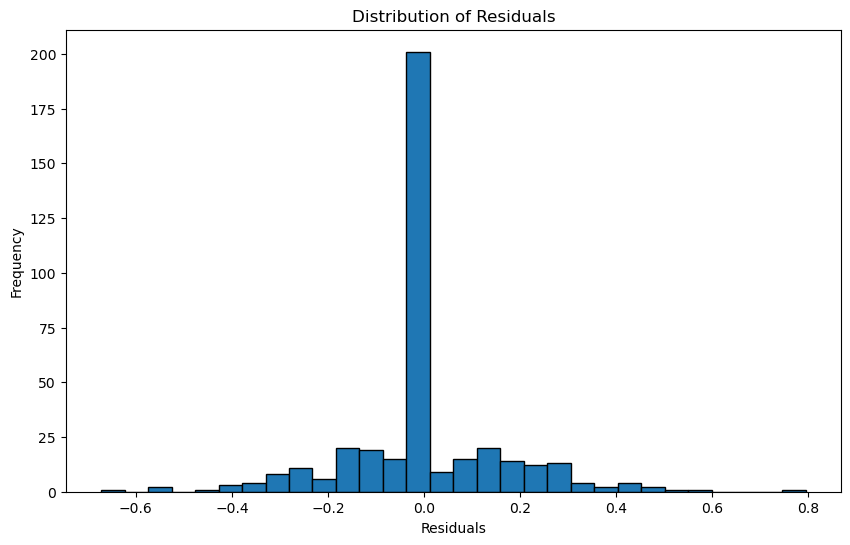

In [873]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

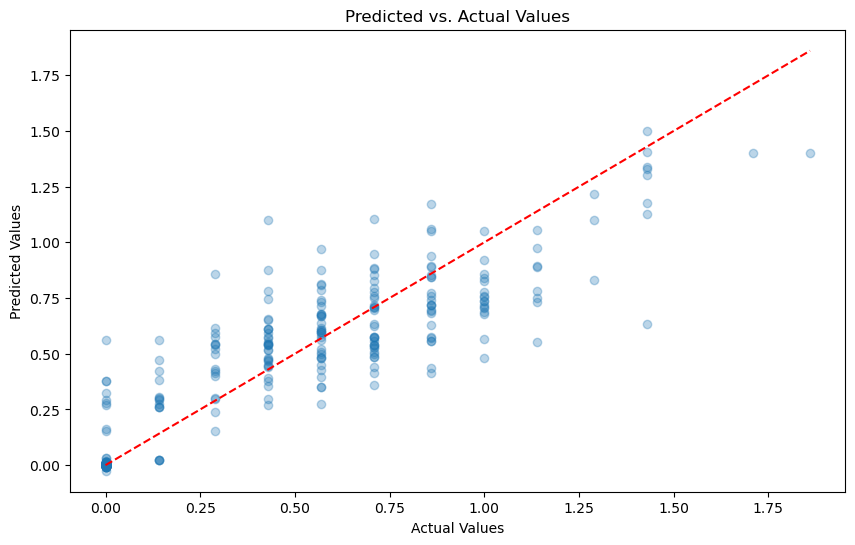

In [874]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.show()